# FEgrow: An Open-Source Molecular Builder and Free Energy Preparation Workflow

**Authors: Mateusz K Bieniek, Ben Cree, Rachael Pirie, Joshua T. Horton, Natalie J. Tatum, Daniel J. Cole**

## Overview

Building and scoring molecules can be further streamlined by employing our established protocol. Here we show how to quickly build a library and score the entire library. 

In [1]:
import pandas as pd
import prody
from rdkit import Chem

import fegrow
from fegrow import ChemSpace
import pathlib


<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


# Load all training ligands

In [2]:
training_ligands = []
for lig_file in pathlib.Path("ligand-train").glob("*.sdf"):
    # load the ligand and remove the hs
    rdkit_mol = Chem.MolFromMolFile(lig_file.as_posix(), removeHs=True)
    training_ligands.append(rdkit_mol)

In [3]:
# load the test molecules
test_mols = []
supplier = Chem.SmilesMolSupplier("smiles-test-SARS.txt")
for lig in supplier:
    lig = Chem.AddHs(lig)
    test_mols.append(lig)

[22:01:38] WARNING: no name column found on line 1
[22:01:38] WARNING: no name column found on line 2
[22:01:38] WARNING: no name column found on line 3
[22:01:38] WARNING: no name column found on line 4
[22:01:38] WARNING: no name column found on line 5
[22:01:38] WARNING: no name column found on line 6
[22:01:38] WARNING: no name column found on line 7
[22:01:38] WARNING: no name column found on line 8
[22:01:38] WARNING: no name column found on line 9
[22:01:38] WARNING: no name column found on line 10
[22:01:38] WARNING: no name column found on line 11
[22:01:38] WARNING: no name column found on line 12
[22:01:38] WARNING: no name column found on line 13
[22:01:38] WARNING: no name column found on line 14
[22:01:38] WARNING: no name column found on line 15
[22:01:38] WARNING: no name column found on line 16
[22:01:38] WARNING: no name column found on line 17
[22:01:38] WARNING: no name column found on line 18
[22:01:38] WARNING: no name column found on line 19
[22:01:38] WARNING: n

In [15]:
fail_mols = [5, 16, 45, 47, 60, 67, 69, 70, 71, 72, 73, 34, 35, 87]
test_mols_fails = [mol for i, mol in enumerate(test_mols) if i in fail_mols]

In [17]:
# as chemspace can only do a single molecule at a time we need to a bit of manual work
# for the first ligand find the best mcs match with the training data
import tqdm
from rdkit.Chem import rdFMCS

def find_best_n_matches(target_ligand, ref_ligands, n_top):
    matched_mols = []
    for ref_lig in tqdm.tqdm(ref_ligands, desc="Finding matches"):
        mcs = rdFMCS.FindMCS(
            [target_ligand, ref_lig],
            ringMatchesRingOnly=True,
            completeRingsOnly=True,
            atomCompare=rdFMCS.AtomCompare.CompareAnyHeavyAtom,
            bondCompare=rdFMCS.BondCompare.CompareAny,
            maximizeBonds=False,
            timeout=1,
        )
        matched_mols.append((mcs.numAtoms, mcs.numBonds, ref_lig, mcs.smartsString))
    matched_mols.sort(key=lambda x: (x[0], x[1]), reverse=True)
    return matched_mols[:n_top]


In [6]:
matches = find_best_n_matches(test_mols[1], training_ligands, 5)

Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:10<00:00, 75.24it/s]


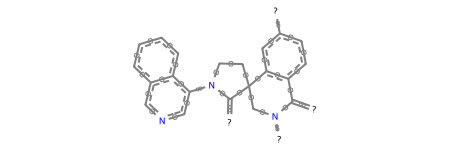

In [7]:
# create the template molecule using the mcs match
mcs_mol = Chem.MolFromSmarts(matches[1][-1])
mcs_mol

In [20]:
# now transfer the coords from the refernce ligand to the mcs template
def transfer_coordinates(reference_ligand: Chem.Mol, template_ligand: Chem.Mol) -> Chem.Mol:
    """
    Transfer the coordinates from the reference to the template ligand.

    Args:
        reference_ligand: The ligand we want to generate the conformers for.
        template_ligand: The ligand whose coordinates should be used as a reference.

    Returns:
        The template ligand with atom positions set to the reference for overlapping atoms.

    """
    matches = reference_ligand.GetSubstructMatch(template_ligand)
    if not matches:
        raise RuntimeError(
            f"A core fragment could not be extracted from the reference ligand using core smarts {Chem.MolToSmarts(template_ligand)}"
        )

    ref_conformer: Chem.Conformer = reference_ligand.GetConformer(0)
    template_conformer = Chem.Conformer()
    for i, atom_match in enumerate(matches):
        ref_atom_position = ref_conformer.GetAtomPosition(atom_match)
        template_conformer.SetAtomPosition(i, ref_atom_position)
    template_ligand.AddConformer(template_conformer, assignId=True)
    return template_ligand

In [9]:
mcs_mol = transfer_coordinates(reference_ligand=matches[1][2], template_ligand=mcs_mol)

In [10]:
# now create the fegrow mol and use this as the template
test_mol = fegrow.RMol(test_mols[1])
test_mol._save_template(mcs_mol)

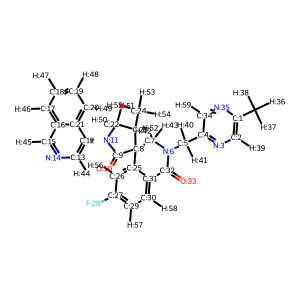

In [11]:
test_mol.rep2D()

In [12]:
test_mol.generate_conformers(num_conf=300)

Generated 300 conformers. 


In [13]:
test_mol.rep3D()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Removed 0 conformers. 


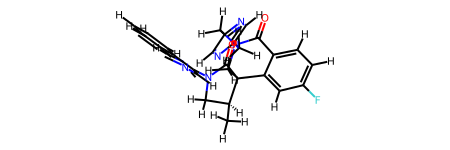

In [14]:
test_mol.remove_clashing_confs(protein="rec_final.pdb")

In [15]:
test_mol.optimise_in_receptor(receptor_file="rec_final.pdb", ligand_force_field="openff")

/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


using ani2x


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/torchani/__init__.py:59: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|███████████████████| 300/300 [06:22<00:00,  1.27s/it]


ID  Conformer      Energy
0    None          0 -984604.386
1    None          1 -984606.332
2    None          2 -984608.948
3    None          3 -984606.478
4    None          4 -984604.388
..    ...        ...         ...
295  None        295 -984608.953
296  None        296 -984606.514
297  None        297 -984608.940
298  None        298 -984608.947
299  None        299 -984608.948

[300 rows x 3 columns]

In [16]:
test_mol.sort_conformers()

ID  Conformer  Energy
0    None          0   0.000
1    None          1   3.693
2    None          2   3.699
3    None          3   3.699
4    None          4   3.700
..    ...        ...     ...
125  None        125   3.725
126  None        126   3.725
127  None        127   3.726
128  None        128   3.726
129  None        129   3.734

[130 rows x 3 columns]

In [17]:
test_mol = fegrow.RMol(test_mol, confId=0)
test_mol.rep3D()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [21]:
test_mol.template.rep3D()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [19]:
fegrow.RMol(training_ligands[30]).rep3D()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [18]:
# create a single function which can pose each ligand in the series
def pose_ligand(target_ligand, reference_ligands, protein_file) -> tuple[fegrow.RMol, fegrow.RMol]:
    # returns the posed ligand and the ligand used as the template
    # for the input ligand generate a pose using the best mcs match as the refernce ligand
    best_matches = find_best_n_matches(target_ligand=target_ligand, ref_ligands=reference_ligands, n_top=10)
    for close_match in best_matches:
        # try each match till we can generate a pose
        # now create the template molecule with the correct coords
        mcs_mol = Chem.MolFromSmarts(close_match[-1])
        mcs_mol = transfer_coordinates(reference_ligand=close_match[2], template_ligand=mcs_mol)
        # make the fegrow mol and use this as the template
        fe_mol = fegrow.RMol(target_ligand)
        fe_mol._save_template(mcs_mol)
        # generate coords we found 300 to work well in asap-alchemy
        try:
            fe_mol.generate_conformers(num_conf=300)
        except ValueError:
            print('Failed to embed trying next match')
            continue
        # if we remove all of the conformers keep cycling through the list to see if this helps
        fe_mol.remove_clashing_confs(protein=protein_file)
        # optimise with ani2x
        fe_mol.optimise_in_receptor(receptor_file=protein_file, ligand_force_field="openff", use_ani=False)
        # sort the conformers so the lowest energy is at id 0
        fe_mol.sort_conformers()
        if fe_mol.GetNumConformers() != 0:
            break
        else:
            print("Removed all conformers trying next match")
    # now purge all but the lowest in energy
    fe_mol = fegrow.RMol(fe_mol, confId=0)
    return fe_mol, fegrow.RMol(close_match[2])

    

    

In [22]:
import tqdm 
import pathlib
pathlib.Path('outputs_fails').mkdir(exist_ok=True)
for i, test_ligand in tqdm.tqdm(enumerate(test_mols_fails), desc="Generating conformers"):
    print(f'Running ligand {i}')
    output_dir = pathlib.Path("outputs_fails").joinpath(f"ligand_{i}")
    if output_dir.exists():
        continue
    posed_ligand, temp_lig = pose_ligand(target_ligand=test_ligand, reference_ligands=training_ligands, protein_file="rec_final.pdb")
    output_dir.mkdir(exist_ok=True, parents=True)
    posed_ligand.to_file(output_dir.joinpath("best_pose.sdf").as_posix())
    temp_lig.to_file(output_dir.joinpath("template_lig.sdf").as_posix())    


Generating conformers: 0it [00:00, ?it/s]

Running ligand 0



Finding matches:  16%|███████████████████████▎                                                                                                                            | 121/770 [00:19<01:25,  7.59it/s]


Finding matches:  37%|██████████████████████████████████████████████████████▍                                                                                             | 283/770 [00:36<01:01,  7.88it/s]


Finding matches:  55%|████████████████████████████████████████████████████████████████████████████████▉                                                                   | 421/770 [00:54<00:41,  8.38it/s]


Finding matches:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 551/770 [01:13<00:22,  9.90it/s]


Finding matches:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 687/770 [01:35<00:22,  3.62it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [01:48<00:00,  7.11it/s]


Generated 300 conformers. 
Removed 300 conformers. 
An rmol doesn't have any conformers. Ignoring.
Removed all conformers trying next match
Generated 300 conformers. 
Removed 17 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 1it [16:38, 998.65s/it]

Running ligand 1



Finding matches:  41%|████████████████████████████████████████████████████████████▏                                                                                       | 313/770 [00:20<00:13, 33.10it/s]


Finding matches:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 643/770 [00:44<00:04, 26.25it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:59<00:00, 12.98it/s]


Generated 300 conformers. 
Removed 26 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 2it [23:32, 654.78s/it]

Running ligand 2



Finding matches:  17%|█████████████████████████▏                                                                                                                          | 131/770 [00:17<01:14,  8.54it/s]


Finding matches:  39%|█████████████████████████████████████████████████████████                                                                                           | 297/770 [00:33<00:54,  8.62it/s]


Finding matches:  58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                             | 449/770 [00:52<01:08,  4.65it/s]


Finding matches:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 583/770 [01:10<00:34,  5.49it/s]


Finding matches:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 725/770 [01:27<00:06,  7.00it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [01:35<00:00,  8.07it/s]


Generated 300 conformers. 
Removed 300 conformers. 
An rmol doesn't have any conformers. Ignoring.
Removed all conformers trying next match
Generated 300 conformers. 
Removed 0 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 3it [30:04, 534.51s/it]

Running ligand 3



Finding matches:  18%|██████████████████████████▎                                                                                                                         | 137/770 [00:12<01:49,  5.78it/s]


Finding matches:  41%|█████████████████████████████████████████████████████████████                                                                                       | 318/770 [00:24<00:43, 10.32it/s]


Finding matches:  62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 480/770 [00:37<00:27, 10.46it/s]


Finding matches:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 626/770 [00:50<00:14,  9.88it/s]


Finding matches:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 761/770 [01:03<00:00, 11.74it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [01:03<00:00, 12.04it/s]


Generated 300 conformers. 
Removed 205 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 4it [33:49, 412.45s/it]

Running ligand 4



Finding matches:  42%|█████████████████████████████████████████████████████████████▌                                                                                      | 320/770 [00:09<00:09, 45.07it/s]


Finding matches:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 617/770 [00:23<00:03, 39.51it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:31<00:00, 24.68it/s]


Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Generated 300 conformers. 
Removed 0 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 5it [39:09, 378.98s/it]

Running ligand 5



Finding matches:  19%|████████████████████████████▊                                                                                                                       | 150/770 [00:10<00:28, 21.57it/s]


Finding matches:  45%|██████████████████████████████████████████████████████████████████                                                                                  | 344/770 [00:21<00:31, 13.46it/s]


Finding matches:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 521/770 [00:32<00:16, 15.48it/s]


Finding matches:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 687/770 [00:43<00:09,  8.67it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:49<00:00, 15.62it/s]


Generated 300 conformers. 
Removed 300 conformers. 
An rmol doesn't have any conformers. Ignoring.
Removed all conformers trying next match
Generated 300 conformers. 
Removed 76 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 6it [42:56, 327.57s/it]

Running ligand 6



Finding matches:  20%|██████████████████████████████▏                                                                                                                     | 157/770 [00:10<00:29, 20.60it/s]


Finding matches:  47%|█████████████████████████████████████████████████████████████████████▌                                                                              | 362/770 [00:20<00:31, 12.77it/s]


Finding matches:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 557/770 [00:31<00:12, 16.88it/s]


Finding matches:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 735/770 [00:42<00:02, 13.74it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:45<00:00, 17.09it/s]


Generated 300 conformers. 
Removed 300 conformers. 
An rmol doesn't have any conformers. Ignoring.
Removed all conformers trying next match
Generated 300 conformers. 
Removed 300 conformers. 
An rmol doesn't have any conformers. Ignoring.
Removed all conformers trying next match
Generated 300 conformers. 
Removed 300 conformers. 
An rmol doesn't have any conformers. Ignoring.
Removed all conformers trying next match
Generated 300 conformers. 
Removed 0 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 7it [47:15, 305.19s/it]

Running ligand 7



Finding matches:  19%|████████████████████████████▊                                                                                                                       | 150/770 [00:10<00:29, 21.26it/s]


Finding matches:  41%|████████████████████████████████████████████████████████████▌                                                                                       | 315/770 [00:20<00:35, 12.94it/s]


Finding matches:  62%|████████████████████████████████████████████████████████████████████████████████████████████                                                        | 479/770 [00:32<00:22, 13.00it/s]


Finding matches:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 648/770 [00:42<00:04, 27.56it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:50<00:00, 15.33it/s]
[23:02:16] Could not triangle bounds smooth molecule.
[23:02:16] Could not triangle bounds smooth molecule.
[23:02:16] Could not triangle bounds smooth molecule.
[23:02:16] Could not triangle bounds smooth molecule.
[23:02:16] Could not triangle bounds smooth molecule.
[23:02:16] Could not triangle bounds smooth molecule.
[23:02:16] Could not triangle bounds smooth molecule.


Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match


Generating conformers: 8it [49:28, 250.25s/it]

Failed to embed trying next match
Running ligand 8



Finding matches:  18%|███████████████████████████                                                                                                                         | 141/770 [00:10<01:02, 10.04it/s]


Finding matches:  44%|█████████████████████████████████████████████████████████████████▋                                                                                  | 342/770 [00:20<00:26, 16.00it/s]


Finding matches:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 521/770 [00:32<00:15, 15.91it/s]


Finding matches:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 692/770 [00:44<00:07, 10.91it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:49<00:00, 15.52it/s]


Generated 300 conformers. 
Removed 0 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 9it [53:16, 243.25s/it]

Running ligand 9



Finding matches:  49%|████████████████████████████████████████████████████████████████████████▍                                                                           | 377/770 [00:11<00:44,  8.77it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:27<00:00, 28.40it/s]


Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Generated 300 conformers. 
Removed 0 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 10it [56:27, 227.29s/it]

Running ligand 10



Finding matches:  35%|███████████████████████████████████████████████████▎                                                                                                | 267/770 [00:15<00:56,  8.83it/s]


Finding matches:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 501/770 [00:30<00:19, 13.75it/s]


Finding matches:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 690/770 [00:45<00:07, 10.85it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:49<00:00, 15.68it/s]
[23:11:27] Could not triangle bounds smooth molecule.
[23:11:27] Could not triangle bounds smooth molecule.
[23:11:27] Could not triangle bounds smooth molecule.
[23:11:27] Could not triangle bounds smooth molecule.
[23:11:27] Could not triangle bounds smooth molecule.
[23:11:27] Could not triangle bounds smooth molecule.
[23:11:27] Could not triangle bounds smooth molecule.
[23:11:27] Could not triangle bounds smooth molecule.
[23:11:27] Could not triangle bounds smooth molecule.
[23:11:27] Could not triangle bounds smooth molecule.
Generating conformers: 11it [57:17, 172.77s/it]

Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Failed to embed trying next match
Running ligand 11



Finding matches:  18%|███████████████████████████▎                                                                                                                        | 142/770 [00:09<00:55, 11.29it/s]


Finding matches:  46%|███████████████████████████████████████████████████████████████████▋                                                                                | 352/770 [00:20<00:20, 20.89it/s]


Finding matches:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 536/770 [00:31<00:11, 20.98it/s]


Finding matches:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 714/770 [00:43<00:01, 30.67it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:47<00:00, 16.19it/s]


Generated 300 conformers. 
Removed 103 conformers. 
Using force field


Generating conformers: 12it [1:01:44, 201.42s/it]

Running ligand 12



Finding matches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:03<00:00, 249.66it/s]


Failed to embed trying next match
Generated 300 conformers. 
Removed 232 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 13it [1:03:18, 169.01s/it]

Running ligand 13



Finding matches:  21%|██████████████████████████████▎                                                                                                                     | 158/770 [00:10<00:27, 22.13it/s]


Finding matches:  47%|█████████████████████████████████████████████████████████████████████▌                                                                              | 362/770 [00:21<00:38, 10.59it/s]


Finding matches:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 556/770 [00:33<00:15, 13.91it/s]


Finding matches:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 737/770 [00:46<00:02, 11.02it/s]


Finding matches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [00:49<00:00, 15.70it/s]


Generated 300 conformers. 
Removed 300 conformers. 
An rmol doesn't have any conformers. Ignoring.
Removed all conformers trying next match
Generated 300 conformers. 
Removed 69 conformers. 


/home/josh/mambaforge/envs/fegrow/lib/python3.11/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.asanyarray(value, dtype=np.float64)


Using force field


Generating conformers: 14it [1:06:54, 286.78s/it]
